In [3]:
import pandas as pd
import numpy as np
import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import spacy
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import resample
from torch.nn.utils.rnn import pad_sequence

import torch
from sklearn.metrics import f1_score
import pandas as pd 
import re
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

# Problem

The aim of this notebook is to develop an LSTM model that accurately predicts which Tweets are about real disasters and which ones are not. Given a wide range of alternative approaches, logistic regression and SVC will be tried as well for benchmarking the LSTM approach.

# EDA

In [74]:
raw_train_df = pd.read_csv("train.csv")
raw_test_df = pd.read_csv("test.csv")

In [75]:
raw_train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [76]:
raw_train_df.shape

(7613, 5)

In [77]:
raw_train_df.duplicated().sum()

0

In [78]:
raw_train_df.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [79]:
raw_train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [80]:
del raw_train_df['keyword']
del raw_train_df['location']
del raw_train_df['id']

The columns 'id', 'location','keyword' were removed due to data sparcity.

In [72]:
# Data preprocessing for deep learning
def text_cleaner(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'https?://\S+', '', text) # remove URLs
    text = re.sub(r"#", "", text)
    return text

train_data = raw_train_df.where((pd.notnull(raw_train_df)),'')
test_data = raw_test_df.where((pd.notnull(raw_test_df)),'')

train_data['text'] = train_data['text'].apply(text_cleaner)
test_data['text'] = test_data['text'].apply(text_cleaner)

df_majority = train_data[train_data['target'] == 0]
df_minority = train_data[train_data['target'] == 1]

df_minority_upsampled = df_minority.sample(replace=True, n=len(df_majority), random_state=123)  # Upsample minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])  # Combine majority class and upsampled minority class

train_data = df_upsampled.sample(frac=1).reset_index(drop=True)  # Shuffle rows

X, Y = train_data['text'], train_data['target']
X_test= test_data['text']

In [90]:
# Embed Data for Deep Learning
def embed(docs):
    nlp = spacy.load('en_core_web_lg')
    docs_tensor = []
    pbar = tqdm.trange(docs.shape[0])
    for t in pbar:
        doc = nlp(docs[t])
        sentence_embeddings = [token.vector for token in doc]
        docs_tensor.append(sentence_embeddings)

    docs_tensor = [torch.tensor(np.array(d)) for d in docs_tensor]
    docs_tensor = pad_sequence(docs_tensor, batch_first=True)

    print(docs_tensor.shape)
    return docs_tensor

X_tensor = embed(X)
X_test_tensor = embed(X_test)
X_train, X_val, Y_train, Y_val = train_test_split(X_tensor, Y, test_size=0.2, random_state= 3)

Y_train = torch.from_numpy(Y_train.values)
Y_val = torch.from_numpy(Y_val.values)
train_dataset = TensorDataset(X_train, Y_train)

# Create dataLoader
batch_size = 50
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(X_train.shape, X_val.shape, X_test_tensor.shape)
print(X_tensor.shape)
print(Y.shape)

100%|██████████| 8684/8684 [01:11<00:00, 122.01it/s]


torch.Size([8684, 32, 300])


100%|██████████| 3263/3263 [00:22<00:00, 142.59it/s]


torch.Size([3263, 33, 300])
torch.Size([6947, 32, 300]) torch.Size([1737, 32, 300]) torch.Size([3263, 33, 300])
torch.Size([8684, 32, 300])
(8684,)


This code splits a dataset into training and validation sets then converts the target variable arrays from the training and validation splits into PyTorch tensors. It then wraps these tensors with their corresponding features into TensorDataset objects for training, validation, and testing. Lastly, it creates DataLoader instances for the training, validation, and test datasets, with a batch size of 50 and shuffling enabled, and prints the shapes of the training, validation, and test feature sets.

# Create Benchmark Models

In [54]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm  import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

In [48]:
# Text Preprocessing for benchmarking
stop_words=set(stopwords.words('english'))
stemming=PorterStemmer()

def clean_text(text):
    text = text.lower() # 1. Convert to lower
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 2. Remove special characters
    tokens = word_tokenize(text) # 3. Split to words
    tokens = [word for word in tokens if word not in stop_words] # 4. Remove stopwords
    tokens = [word for word in tokens if not word.isdigit()] # 5. Remove numbers
    tokens = [stemming.stem(word) for word in tokens] # 7. Apply Stemming
    return ' '.join(tokens) # To return these single words back into one string

train_df1_b = train_df1.copy()
train_df1_b['cleaned_text'] = train_df1_b['text'].apply(clean_text)

tf_idf=TfidfVectorizer()
x_b = tf_idf.fit_transform(train_df1_b['cleaned_text'])
y_b = train_df1_b['target']

X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(x_b,y_b,test_size=0.2,random_state=0)

In [ ]:
# SVC benchmark model
svc = SVC()
svc.fit(X_train_b,y_train_b)
svc_y_pred_b = svc.predict(X_test_b)
accuracy = accuracy_score(y_test_b, svc_y_pred_b)
print(f'Accuracy: {accuracy:.4f}')
print("Classification Report of SVC:\n", classification_report(y_test_b, svc_y_pred_b))

print('Training Accuracy Base SVC :', svc.score(X_train_b,y_train_b))
print('Test Accuracy Base SVC :', svc.score(X_test_b,y_test_b))

# SVC Hyperparameter tuning
svc = SVC()
param_grid={
    'C':[0.001,0.01,0.1,1,10,],
    'class_weight': [None, 'balanced']
           }
grid_search_svc = GridSearchCV(svc, param_grid,cv=5,scoring='accuracy')
grid_search_svc.fit(X_train_b, y_train_b)
best_model_svc = grid_search_svc.best_estimator_

y_train_pred_svc=best_model_svc.predict(X_train_b)
trainning_accuracy_svc=accuracy_score(y_train_b, y_train_pred_svc)

y_test_pred_svc=best_model_svc.predict(X_test_b)
testing_accuracy_svc=accuracy_score(y_test_b, y_test_pred_svc)

print(f"Training Accuracy Tuned SVC : {trainning_accuracy_svc * 100:.2f}")
print(f"Testing Accuracy Tuned SVC : {testing_accuracy_svc * 100:.2f}")

Accuracy: 0.7834
Classification Report of SVC:
               precision    recall  f1-score   support

           0       0.74      0.93      0.83       841
           1       0.88      0.59      0.71       664

    accuracy                           0.78      1505
   macro avg       0.81      0.76      0.77      1505
weighted avg       0.80      0.78      0.77      1505

Training accuracy: 0.9720744680851063
Test accuracy: 0.7833887043189369
Training Accuracy of SVC : 98.02
Testing Accuracy  of  SVC: 79.14


In [53]:
# Logistic Regression benchmark model
log_r = LogisticRegression()
log_r.fit(X_train_b,y_train_b)
logr_y_pred_b = log_r.predict(X_test_b)
accuracy = accuracy_score(y_test_b, logr_y_pred_b)
print(f'Accuracy Base Logistic Regression: {accuracy:.4f}')
print("Classification Report of Logistic Regression:\n", classification_report(y_test_b, logr_y_pred_b))

# Hyperparameter tune the logistic regression model 
param_grid={'C':[0.001,0.01,0.1,1,10,100]}
grid_search_lr = GridSearchCV(log_r, param_grid,cv=5,scoring='accuracy')
grid_search_lr.fit(X_train_b,y_train_b)

best_model_lr = grid_search_lr.best_estimator_
y_train_pred_lr = best_model_lr.predict(X_train_b)
trainning_accuracy_lr = accuracy_score(y_train_b, y_train_pred_lr)

y_train_pred_lr = best_model_lr.predict(X_train_b)
trainning_accuracy_lr = accuracy_score(y_train_b, y_train_pred_lr)

y_test_pred_lr = best_model_lr.predict(X_test_b)
testing_accuracy_lr = accuracy_score(y_test_b, y_test_pred_lr)

print(f"Training Accuracy Tuned Logistic Regression : {trainning_accuracy_lr * 100:.2f}")
print(f"Testing Accuracy Tuned Logistic Regression: {testing_accuracy_lr * 100:.2f}")

Accuracy: 0.7894
Classification Report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       841
           1       0.87      0.62      0.72       664

    accuracy                           0.79      1505
   macro avg       0.81      0.77      0.78      1505
weighted avg       0.80      0.79      0.78      1505

Training Accuracy of Logistic Regression : 89.00
Testing Accuracy  of Logistic Regression: 78.94


The two benchmark models evaluated are Support Vector Classification (SVC) and Logistic Regression. The SVC model achieves a test accuracy of approximately 79.14%, with training accuracy of 98.02%. The Logistic Regression model shows a slightly lower test accuracy of 78.94% with a training accuracy of 89.00%. Overfitting is seen in both models.

# LSTM and GRU Model Architectures

In [81]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_classes = num_classes
        self.linear_i = nn.Linear(self.input_size, self.hidden_size)  # Linear layers for updating hidden state
        self.linear_h = nn.Linear(self.input_size, self.hidden_size)  # Linear layers for updating hidden state
        self.linear_f = nn.Linear(self.input_size, self.hidden_size)  # Linear layers for updating hidden state
        self.fc = nn.Linear(self.hidden_size, self.num_classes) # Fully connected layer for classification
        
    def forward(self, x):
        f = torch.sigmoid(self.linear_f(x))
        i = torch.sigmoid(self.linear_i(x))
        tilde_h = self.linear_h(x)
        f_prime = f / (f + i)
        i_prime = i / (f + i)
        h_prev = torch.zeros((x.shape[0], self.hidden_size))
        
        for i in range(x.shape[1]):
            f_prime_t = f_prime[:, i, :]
            i_prime_t = i_prime[:, i, :]
            tilde_h_t = tilde_h[:, i, :]
            h_prev = f_prime_t * h_prev + i_prime_t * tilde_h_t # Update hidden state with dropout
        out = self.fc(h_prev)
        return out

This LSTM model is a custom implementation that modifies the typical architecture of an LSTM by incorporating specific linear transformations for input and forget gates. The model takes inputs and applies linear layers to transform these inputs into hidden states, followed by sigmoid activation to compute the forget and input gate values, which control the information flow. Finally, the hidden states are passed through a fully connected layer to produce the model's output for classification purposes, effectively making it suitable for handling time-series or sequential data.

In [82]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size,num_layers, dropout=0.2, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h_0)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

This GRU (Gated Recurrent Unit) model uses PyTorch's nn.GRU class for its core recurrent layer. The GRU layer is configured with a specific number of layers and a dropout rate to mitigate overfitting, processing the input sequences batch-wise. The output from the GRU layer is then fed into a fully connected linear layer that maps the hidden state to the desired number of output classes.

In [83]:
class EarlyStopping():
    def __init__(self, patience):
        super(EarlyStopping, self).__init__()
        self.patience = patience
        self.counter = 0
        self.last_acc = float("-inf")
        
    def to_stop(self, acc):
        if acc < self.last_acc:
            if self.patience == self.counter:
                return True
            self.counter += 1
        else:
            self.counter = 0
        self.last_acc = acc
        return False 

This Python class implements an early stopping mechanism to prevent overfitting. It is initialized with a 'patience' parameter, which specifies the number of epochs to continue training without improvement in accuracy before stopping. The to_stop method checks if the current accuracy (acc) is less than the last recorded accuracy; if it is, the counter is incremented and the method checks if it has reached the patience limit to decide whether to stop training. If the current accuracy improves, the counter is reset, encouraging continued training.

# Model Training & Results

In [84]:
def category_from_output(output):
    category_index = torch.argmax(output).item()
    return category_index

def evaluate_model(model, val_dataloader):
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for batch_X, batch_Y in val_dataloader:   # Zero the gradients
            outputs = model(batch_X)  
            _, predictions = torch.max(outputs, 1)
            n_samples  += batch_Y.shape[0]
            n_correct += (predictions == batch_Y).sum().item()
        acc = 100* n_correct / n_samples
        print(f'accuracy ={acc:.4f}')
    model.train()
    return acc

def train(model, epoch, early_stopping, optimizer, criterion):
    to_stop = False
    for epoch in range(num_epochs):
        iteration = 0
        n_correct = 0
        n_samples = 0
        for batch_X, batch_Y in train_dataloader: # Zero the gradients
            optimizer.zero_grad()  # Forward pass
            output = model(batch_X)  # Compute loss
            loss = criterion(output, batch_Y)

            _, predictions = torch.max(output, 1)
            n_samples  += batch_Y.shape[0]
            n_correct += (predictions == batch_Y).sum().item()
            acc = 100 * n_correct / n_samples

            loss.backward() # Backward pass
            optimizer.step()
            iteration += 1
            if iteration%100==0:
                eval_acc = evaluate_model(model, val_dataloader)
                if early_stopping.to_stop(eval_acc):
                    to_stop = True
                    break
                print(f'Training accuracy ={acc:.4f}, Eval accuracy = {eval_acc:.4f}, {early_stopping.counter}')
                print(f'epoch: {epoch+1}, step {iteration+1}, loss = {loss.item():.4f}')

The category_from_output function above extracts the category index from the model's output by identifying the maximum value's index, representing the predicted class. The evaluate_model function assesses the model's performance on the validation dataset by computing the accuracy as the percentage of correctly predicted instances and resets the model to training mode after evaluation. The train function orchestrates the training process over multiple epochs, handling forward and backward passes, loss computation, and updates to the model's weights through an optimizer; it also incorporates an early stopping mechanism that halts training if the validation accuracy does not improve over a specified number of iterations (patience parameter).

In [91]:
# First Model - LSTM
input_size = 300 # feed RNN one row at a time 
hidden_dims = 200

n_categories = 2
num_epochs = 40
learning_rate = 0.001
all_losses = []

model = LSTM(input_size, hidden_dims, n_categories)
early_stopping = EarlyStopping(2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train(model, num_epochs, early_stopping, optimizer, criterion)

accuracy =50.3166
Training accuracy =49.9800, Eval accuracy = 50.3166, 0
epoch: 1, step 101, loss = 0.6875
accuracy =50.3166
Training accuracy =51.8400, Eval accuracy = 50.3166, 0
epoch: 2, step 101, loss = 0.6946
accuracy =51.5832
Training accuracy =50.8000, Eval accuracy = 51.5832, 0
epoch: 3, step 101, loss = 0.6854
accuracy =51.9286
Training accuracy =51.9200, Eval accuracy = 51.9286, 0
epoch: 4, step 101, loss = 0.6844
accuracy =52.1589
Training accuracy =52.6000, Eval accuracy = 52.1589, 0
epoch: 5, step 101, loss = 0.6716
accuracy =53.5406
Training accuracy =54.0000, Eval accuracy = 53.5406, 0
epoch: 6, step 101, loss = 0.6797
accuracy =53.5982
Training accuracy =54.8600, Eval accuracy = 53.5982, 0
epoch: 7, step 101, loss = 0.6665
accuracy =70.5239
Training accuracy =61.6200, Eval accuracy = 70.5239, 0
epoch: 8, step 101, loss = 0.6661
accuracy =76.1658
Training accuracy =73.8000, Eval accuracy = 76.1658, 0
epoch: 9, step 101, loss = 0.5458
accuracy =78.1232
Training accuracy =

In [92]:
# Second Model - GRU
num_epochs = 10
early_stopping = EarlyStopping(2)
n_hidden =2
model1 = GRU(input_size, hidden_dims, n_hidden, n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
train(model1, num_epochs, early_stopping, optimizer, criterion)

accuracy =78.2959
Training accuracy =68.5400, Eval accuracy = 78.2959, 0
epoch: 1, step 101, loss = 0.5656
accuracy =81.1744
Training accuracy =81.1400, Eval accuracy = 81.1744, 0
epoch: 2, step 101, loss = 0.4203
accuracy =82.2683
Training accuracy =83.3400, Eval accuracy = 82.2683, 0
epoch: 3, step 101, loss = 0.4983
accuracy =83.7651
Training accuracy =85.4600, Eval accuracy = 83.7651, 0
epoch: 4, step 101, loss = 0.3890
accuracy =83.3621
Training accuracy =87.3000, Eval accuracy = 83.3621, 1
epoch: 5, step 101, loss = 0.1587
accuracy =83.8803
Training accuracy =89.4200, Eval accuracy = 83.8803, 0
epoch: 6, step 101, loss = 0.2241
accuracy =84.1681
Training accuracy =91.3800, Eval accuracy = 84.1681, 0
epoch: 7, step 101, loss = 0.1779
accuracy =84.7438
Training accuracy =92.5000, Eval accuracy = 84.7438, 0
epoch: 8, step 101, loss = 0.2655
accuracy =86.0679
Training accuracy =93.5400, Eval accuracy = 86.0679, 0
epoch: 9, step 101, loss = 0.0915
accuracy =86.4134
Training accuracy =

In [96]:
# Evaluate Both Models
eval_acc = evaluate_model(model, val_dataloader)
print(f'LSTM eval accuracy: {eval_acc:.4f}')

eval_acc = evaluate_model(model1, val_dataloader)
print(f'GRU eval accuracy: {eval_acc:.4f}')

accuracy =84.9165
LSTM eval accuracy: 84.9165
accuracy =87.5072
GRU eval accuracy: 87.5072


In [94]:
with torch.no_grad():
    outputs = model1(X_test_tensor)
    _, predictions = torch.max(outputs, 1)
submission = pd.DataFrame({'id': test_data['id'], 'target': predictions})


# Conclusion

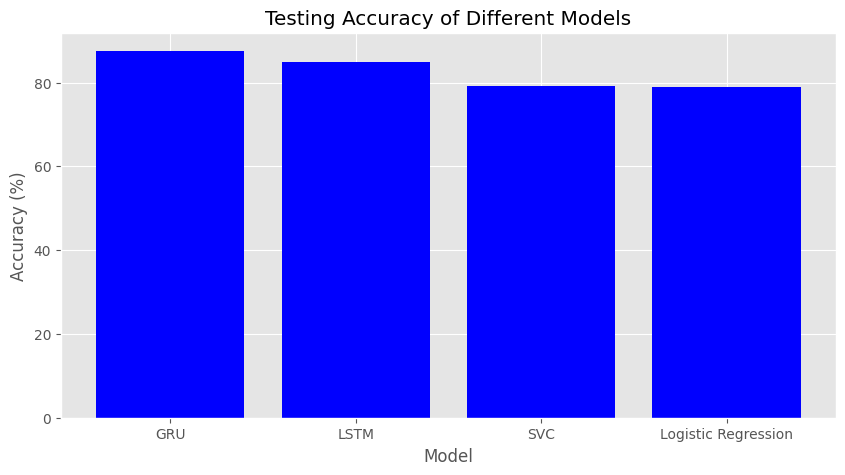

In [99]:
#dataframe of testing accruacy results
data = {
    'Model': ['GRU', 'LSTM', 'SVC', 'Logistic Regression'],
    'Accuracy': [87.5072, 84.9165, 79.14, 78.94]
}

# Convert the dictionary to a DataFrame
df_results = pd.DataFrame(data)

import matplotlib.pyplot as plt

# Set the style (optional)
plt.style.use('ggplot')

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(df_results['Model'], df_results['Accuracy'], color='blue')

# Adding titles and labels
plt.title('Testing Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')

# Display the plot
plt.show()

The GRU model outperformed the other models in terms of accuracy, with an accuracy of 87.5%. The LSTM model also performed well, with an accuracy of 84.9%. The benchmark models, SVC and Logistic Regression, had accuracies of 79.1% and 78.9%, respectively. The bar chart above shows the testing accuracy of the different models. 

Future work would include fine tuning the GRU model in general and to be able to handle larger batch sizes and thereby increase GPU utilization, which could increase accuracy further.